In [49]:
from pathlib import Path

import numpy as np
import pandas as pd
from transformers import BertTokenizer
import torch.nn.functional as F
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import norm, wilcoxon, ttest_rel

In [60]:
# 'bert-base-multilingual-uncased', 
MODELS = ['bert-base-uncased', 'runs/Dec11_09-07-58_elm22']
target_path = Path('runs') / 'crows_pairs/data/crows_pairs_anonymized.csv'

--- bert-base-uncased ---
-26.02256100795756 -26.613938328912468
Ttest_relResult(statistic=-4.377205986556729, pvalue=1.2848758026769643e-05)
WilcoxonResult(statistic=437365.0, pvalue=7.450508167014153e-15)
--- runs/Dec11_09-07-58_elm22 ---
-31.208946949602126 -31.4270775862069
Ttest_relResult(statistic=-2.2136446108818815, pvalue=0.027002512974334914)
WilcoxonResult(statistic=514633.5, pvalue=0.0013362676131256314)


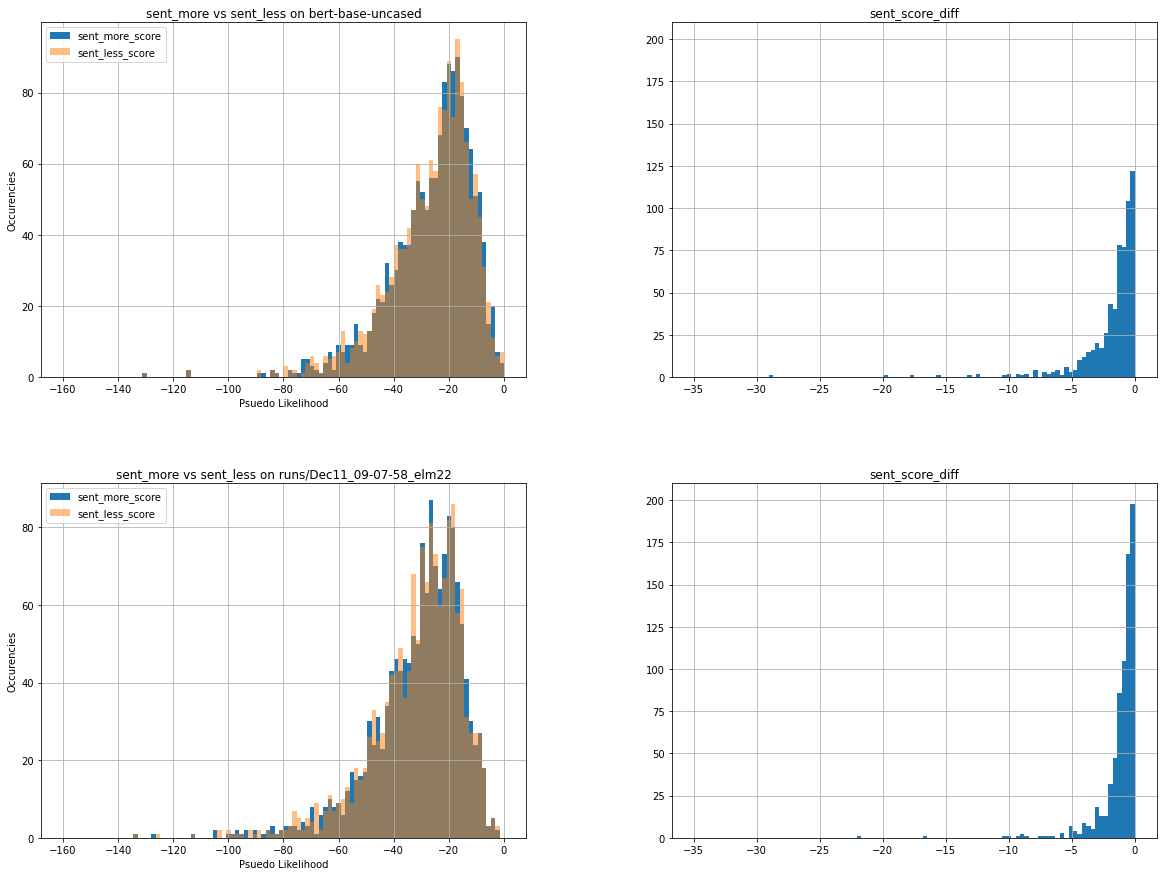

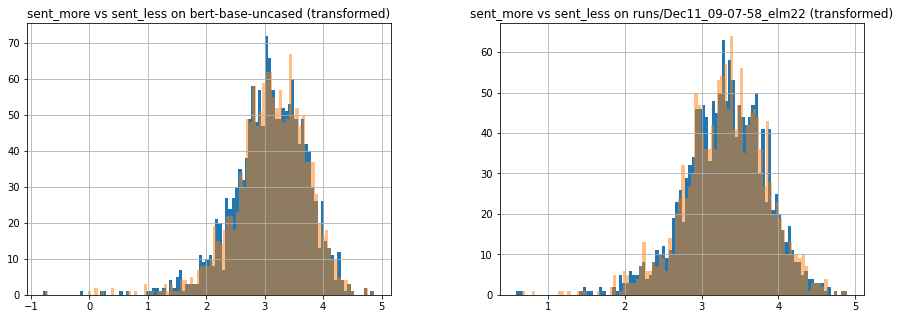

In [68]:
fig, ax = plt.subplots(len(MODELS), 2, figsize=[20.0, 15.0])
fig2, ax2 = plt.subplots(1, len(MODELS), figsize=[15.0, 5.0])
# indeces = range(0, 1508)
# indeces = np.random.choice(indeces, 500)

df_dict = {}
for n, model in enumerate(MODELS):
    print(f'--- {model} ---')
    df_dict[model] = pd.read_csv(target_path / model / 'results.csv')
    df = df_dict[model]# .iloc[indeces]
    print(df['sent_more_score'].mean(), df['sent_less_score'].mean())
    df['sent_score_diff'] = df['sent_more_score'] - df['sent_less_score']
    df['log_sent_more_score'] = np.log(-df['sent_more_score'])
    df['log_sent_less_score'] = np.log(-df['sent_less_score'])
    t_result = ttest_rel(df['log_sent_more_score'], df['log_sent_less_score'])
    print(t_result)
    w_result = wilcoxon(df['sent_more_score'], df['sent_less_score'], zero_method='zsplit', correction=True)
    print(w_result)

    df.hist('sent_more_score', ax=ax[n][0], bins=100, label='sent_more_score', range=[-160, 0])
    df.hist('sent_less_score', ax=ax[n][0], bins=100, alpha=.5, label='sent_less_score', range=[-160, 0])
    ax[n][0].set_xlabel('Psuedo Likelihood')
    ax[n][0].set_ylabel('Occurencies')

    ax[n][0].legend(loc='upper left')
    
    df.hist('log_sent_more_score', ax=ax2[n], bins=100)
    df.hist('log_sent_less_score', ax=ax2[n], bins=100, alpha=.5)
    ax2[n].set_title(f'sent_more vs sent_less on {model} (transformed)')
    df.hist('sent_score_diff', ax=ax[n][1], bins=100, range=[-35, 0])
    ax[n][0].set_title(f'sent_more vs sent_less on {model}')
    ax[n][1].set_ylim([0, 210])

# 考察
* 尤度変わりすぎじゃね？（BERT non-ml vs ml, base vs large)に比べても...
  * 割と悪影響している説
     * 元のBERTが出力する尤度から変わらないように制約すべき？